In [80]:
import pandas as pd
import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.font_manager as fm
import numpy as np
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [211]:
data = pd.read_csv("new.csv", encoding='utf-8')

data = data.drop(data.columns[[1,2,5,6,8,9,11,12,14,15,16,17,18,19,20,21,22,23]], axis='columns')

data = data.drop([0,1],0)

data.columns=['date','buyer_code','buyer','product','quantity','price','locate'] #거래일, 거래처, 물품, 수량, 가격, 출고지명

data = data.dropna(axis = 0)

data = data.reset_index()

data = data.drop(data.columns[[0]], axis='columns')


data['buyer_code'] = pd.to_numeric(data['buyer_code'])

code_index = data[data['buyer_code'] > 90000].index

data = data.drop(index = code_index)

data = data.reset_index()

data = data.drop(data.columns[[0]], axis='columns')

for _ in tqdm.trange(len(data['date'])):
    data['date'][_] = str(data['date'][_].replace("-",""))
    data['quantity'][_] = int(data['quantity'][_].replace(",",""))
    data['price'][_] = int(data['price'][_].replace(",",""))
    data['buyer_code'][_] = int(data['buyer_code'][_])

pre_data = data #전처리 후 저장

pre_data.to_csv("pre-data.csv", header=True, index=False, encoding='cp949')

100%|██████████| 132126/132126 [04:41<00:00, 469.16it/s]


In [212]:
pre_data = data #전처리 후 저장|

In [213]:
#월별

for _ in tqdm.trange(len(pre_data)):
    pre_data['date'][_] = pre_data['date'][_][0:6]

pre_data = pre_data.drop(pre_data.columns[[1,2,5,6]], axis='columns')

per_month = pre_data.groupby(['date', 'product']).sum()

per_month.to_csv("per_month.csv", header=True, index=True, encoding='cp949')

100%|██████████| 132126/132126 [02:13<00:00, 986.21it/s]


In [216]:
#품목별 예측 전처리

data_month = pd.read_csv("per_month.csv", encoding='cp949')

# data_month = pd.read_csv("original/per_month_original.csv", encoding='cp949')
# new_month = pd.read_csv("per_month.csv", encoding='cp949')
# data_month = pd.concat([data_month, new_month])
# data_month = data_month.reset_index()
# data_month = data_month.drop(data_month.columns[[0]], axis='columns')
data_month.to_csv("original/per_month_original.csv", header=True, index=False, encoding='cp949')
per_product = data_month
per_product = per_product.groupby(['product', 'date']).sum()
per_product.to_csv("per_product_month.csv", encoding='cp949')
per_product = pd.read_csv("per_product_month.csv", encoding='cp949')


for i in tqdm.trange(len(per_product["product"])):
    if ("유흥" in per_product["product"][i]) or ("가정" in per_product["product"][i]) or ("군납" in per_product["product"][i]) or ("업소" in per_product["product"][i]) or ("수출" in per_product["product"][i]) or ("면세" in per_product["product"][i]):
        per_product["product"][i] = per_product["product"][i].replace(" ", "")
        per_product["product"][i] = per_product["product"][i][0:len(per_product["product"][i])-3]
        
  
product_list1 = list(set(per_product['product']))
product_list2 = list(set(per_product['product']))

per_product = per_product.groupby(['product', 'date']).sum()

for i in range(0,len(product_list1)):
    if "/" in product_list1[i]:
        product_list1[i] = product_list1[i].replace("/","_")

for i in tqdm.trange(0,len(product_list2)):
    path = "per_product_month/" + product_list1[i] + ".csv"
    per_product.loc[product_list2[i]].to_csv(path, header=True, index=True, encoding='cp949')

100%|██████████| 58/58 [00:00<00:00, 150.27it/s]


                 Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0630           +0.0000j            2.0630            0.5000
-----------------------------------------------------------------------------
화요17차례주의 1월 예상 판매량은  26 개 입니다.
                             ARIMA Model Results                              
Dep. Variable:             D.quantity   No. Observations:                   34
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -56.461
Method:                       css-mle   S.D. of innovations              1.269
Date:                Sun, 08 Mar 2020   AIC                            118.923
Time:                        14:20:19   BIC                            123.502
Sample:                             1   HQIC                           120.484
                                                                              
                       coe

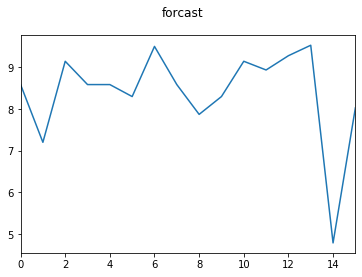

In [217]:
# 제품별 csv 파일 읽기 - 파일 크기별 정렬

forecast = pd.DataFrame(columns=['product', 'quantity', 'lower_limit', 'upper_limit' ,'from_month'])

path_dir = "per_product_month"

file_list = os.listdir(path_dir)

# Loop and add files to list.
pairs = []
for file in file_list:

    # Use join to get full file path.
    location = os.path.join(path_dir, file)

    # Get size and add to list of tuples.
    size = os.path.getsize(location)
    pairs.append((size, file))

# Sort list of tuples by the first element, size.
pairs.sort(key=lambda s: s[0], reverse=True)

for j in range(0, len(pairs)):
  path_product = path_dir + "/" + pairs[j][1]
  product = pd.read_csv(path_product, encoding='cp949')
  product['quantity'] = product['quantity'].astype(float)
  if len(product) > 12:
    for i in range(0,len(product)):
      if product['quantity'][i] <= 0:
        product['quantity'][i] = 0
      else:
        product['quantity'][i] = math.log(product['quantity'][i])
    product = product[:len(product)-1]

    data = pd.Series(product.quantity)
    # plot_acf(data)
    # plot_pacf(data)
    plt.close()

    model = ARIMA(data, order=(1,1,0))
    model_fit = model.fit(trend='c',full_output=True, disp=5)
    print(model_fit.summary())

    fig, ax = plt.subplots()
    fig.suptitle('forcast')
    ax = data.plot(ax=ax)
    fig = model_fit.plot_predict() #1000, 1253, dynamic=True, ax=ax, plot_insample=False, alpha=0.05
    plt.close()

    fore = model_fit.forecast(steps=1)

    name = int(str(data_month['date'][len(data_month)-1])[4:6])+1
    if name >= 12:
      name = 1
    print('{}의 {}월 예상 판매량은 '.format((pairs[j][1])[:len(pairs[j][1])-4], name), int(math.exp(float(fore[0]))), '개 입니다.')
    forecast = forecast.append(pd.DataFrame([[(pairs[j][1])[:len(pairs[j][1])-4], int(math.exp(float(fore[0]))), int(math.exp(float(fore[2][0][0]))), int(math.exp(float(fore[2][0][1]))), len(product)]], columns=['product', 'quantity','lower_limit', 'upper_limit' ,'from_month']), ignore_index=True)

name = int(str(data_month['date'][len(data_month)-1])[4:6])+1
if name >= 12:
  name = 1
filename = str(name) + '월 판매량 예측.csv'
forecast.to_csv(filename, header=True, index=False, encoding='cp949')